In [1]:
# import importnt libraries such as numpy , pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#load the datasetfrom the day8mmm bucket.
df = pd.read_csv("s3://day8mmm/citrus.csv")   
df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [3]:
#here we get the basic information of the data
df.info

<bound method DataFrame.info of             name  diameter  weight  red  green  blue
0         orange      2.96   86.76  172     85     2
1         orange      3.91   88.05  166     78     3
2         orange      4.42   95.17  156     81     2
3         orange      4.47   95.60  163     81     4
4         orange      4.48   95.76  161     72     9
...          ...       ...     ...  ...    ...   ...
9995  grapefruit     15.35  253.89  149     77    20
9996  grapefruit     15.41  254.67  148     68     7
9997  grapefruit     15.59  256.50  168     82    20
9998  grapefruit     15.92  260.14  142     72    11
9999  grapefruit     16.45  261.51  152     74     2

[10000 rows x 6 columns]>

In [4]:
#checking the nullvaules in the dataset
df.isnull().sum()

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64

In [5]:
#check the univlues in the column name
df.name.unique()

array(['orange', 'grapefruit'], dtype=object)

In [6]:
#change the obj type to int for the binry classification 
df['name'] = df['name'].map({'grapefruit': 1, 'orange': 0}) 

In [7]:
#check agin for the execution
df.name.unique()

array([0, 1])

<Axes: xlabel='name', ylabel='count'>

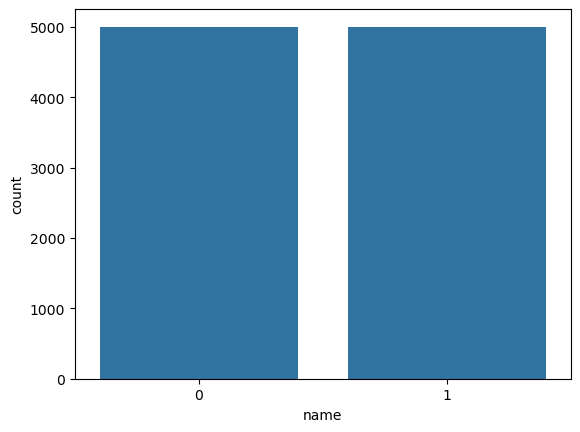

In [8]:
sns.countplot(x=df['name'], data=df)    # countplot of target variable also we can see that the data distribution is almost equal. 

#import boto3 and sagemaker and get the execution role, with region , and defining the BUCKET '''day8mmm'''given the prefix of identity fruit.

In [9]:
#import boto3
import os
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()   
region = boto3.Session().region_name   
smclient = boto3.Session().client("sagemaker")    
bucket = "day8mmm"
prefix = ("identifyfruit") 
print (region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
us-east-1


In [10]:

train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729),[int(0.7 * len(df)), int(0.9 * len(df))])

pd.concat([train_data["name"], train_data.drop("name", axis=1)], axis=1).to_csv(
 "train.csv", index=False, header=False
)  
pd.concat([validation_data["name"], validation_data.drop("name", axis=1)], axis=1).to_csv(
    "validation.csv", index=False, header=False)
pd.concat([test_data["name"], test_data.drop("name", axis=1)], axis=1).to_csv(
 "test.csv", index=False, header=False
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
# Assign the target variable(wnat to predict variable) and the independent variables (features)for the traning and testing set.
train_y = train_data["name"]
train_X = train_data.drop("name", axis=1)
test_y = test_data["name"]
test_X = test_data.drop("name", axis=1)


In [12]:
# by using the boto3 we save the validation and train files into the s3 bucket with specific prefix.
boto3.Session().resource("s3").Bucket(bucket).Object(
 os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
 os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = df.drop(["name"], axis=1)  
y = df["name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: XGBoost Model Training
xg_cls = xgb.XGBClassifier(objective='binary:logistic', seed=42)
xg_cls.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = xg_cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.984


In [17]:
#logistic regressions 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
logmodel = LogisticRegression()
logmodel.fit(train_X,train_y)

predictions = logmodel.predict(test_X)
print(classification_report(test_y,predictions))


              precision    recall  f1-score   support

           0       0.97      0.92      0.95       505
           1       0.92      0.97      0.95       495

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In the hp tuning job we generate the unique job name and time,during the configration learning rate (eta),set the minimum sum of the weight in chid with min 1 and max 10 

In [18]:
from time import gmtime, strftime, sleep

tuning_job_name = "xgboost-tuningjob-" + strftime("%d-%H-%M-%S", gmtime())#name and time
print(tuning_job_name)

# config tuning job
tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",     
            },
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "min_child_weight",    
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",    # # L1 regularization term
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "max_depth",    # Maximum depth of a tree
            }
        ],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 10, "MaxParallelTrainingJobs": 3},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:accuracy", "Type": "Maximize"},
}

xgboost-tuningjob-29-10-25-03


In [19]:
from sagemaker.image_uris import retrieve

training_image = retrieve(framework="xgboost", region=region, version="1.5-1")    # Retrieving the URI of the pre-built Docker image for XGBoost

# S3 input paths for training and validation data
s3_input_train = "s3://{}/{}/train".format(bucket, prefix)
s3_input_validation = "s3://{}/{}/validation/".format(bucket, prefix)

# configuration for the SageMaker training job
training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},    # algorithm and its training image
    "InputDataConfig": [    # input data configuration for training and validation
        {
            "ChannelName": "train",    # Channel name for training data
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,    # S3 path for training data
                }
            },
        },
        {
            "ChannelName": "validation",    # Channel name for validation data
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,   # S3 path for validation data
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)},    # output data configuration for storing model artifacts
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},    # resource configuration for training instances
    "RoleArn": role,   # IAM role 
    "StaticHyperParameters": {    # static hyperparameters for the XGBoost algorithm
        "eval_metric": "auc",
        "num_round": "100",
        "objective": "binary:logistic",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},    #  stopping conditions for the training job
}

In [20]:
# creating the hyperparameter tuning job
smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:263245924849:hyper-parameter-tuning-job/xgboost-tuningjob-29-10-25-03',
 'ResponseMetadata': {'RequestId': '80f74e51-e879-4e06-aaea-c40a1e7dd6fa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '80f74e51-e879-4e06-aaea-c40a1e7dd6fa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Wed, 29 Nov 2023 10:25:25 GMT'},
  'RetryAttempts': 0}}

In [21]:
# status of hp
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)["HyperParameterTuningJobStatus"]

'InProgress'

In [28]:
# Job name of hp
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobName']

'xgboost-tuningjob-28-20-26-32'

In [22]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

10 training jobs have completed


In [23]:
from pprint import pprint
# extracting best training job from the rest
if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 29, 10, 25, 33, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.9819999933242798},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 29, 10, 29, 27, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:263245924849:training-job/xgboost-tuningjob-29-10-25-03-003-5ec2f4b8',
 'TrainingJobName': 'xgboost-tuningjob-29-10-25-03-003-5ec2f4b8',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 29, 10, 27, 30, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.2717722184629703',
                          'eta': '0.6120249159639731',
                          'max_depth': '5',
                          'min_child_weight': '1.6780671799069247'}}


In [24]:
# Now training the model with the best hp values
xgboost_job = "xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", xgboost_job)

s3_input_train = "s3://{}/{}/train".format(bucket, prefix)
s3_input_validation = "s3://{}/{}/validation/".format(bucket, prefix)

training_job_definition = {
    "RoleArn": role,
    "TrainingJobName": xgboost_job,
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "HyperParameters": {
        "eval_metric": "auc",
        "num_round": "100",
        "objective": "binary:logistic",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
        'alpha': '0.2717722184629703',
         'eta': '0.6120249159639731',
           'max_depth': '5',
         'min_child_weight': '1.6780671799069247'
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

Job name is: xgboost-2023-11-29-10-33-50


In [25]:
sm = boto3.client("sagemaker")
sm.create_training_job(**training_job_definition)
# checking the status of training
status = sm.describe_training_job(TrainingJobName=xgboost_job)["TrainingJobStatus"]
print(status)
sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=xgboost_job)
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=xgboost_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress


In [26]:
# creating a model using the specified configuration.
xgboost_hosting_container = {
    "Image": training_image,
    "ModelDataUrl": sm.describe_training_job(TrainingJobName=xgboost_job)["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm.create_model(
    ModelName=xgboost_job, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:263245924849:model/xgboost-2023-11-29-10-33-50


In [27]:
# configuring endpoint with unique name based on current time
xgboost_endpoint_config = "xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(xgboost_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": xgboost_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

xgboost-endpoint-config-2023-11-29-10-38-52
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:263245924849:endpoint-config/xgboost-endpoint-config-2023-11-29-10-38-52


In [28]:
%%time

# configuring, creating, waiting and then checking the status again of an endpoint
xgboost_endpoint = "xgboost-endpoint-" + strftime("%Y%m%d%H%M", gmtime())
print(xgboost_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=xgboost_endpoint, EndpointConfigName=xgboost_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=xgboost_endpoint)

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

xgboost-endpoint-202311291038
arn:aws:sagemaker:us-east-1:263245924849:endpoint/xgboost-endpoint-202311291038
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:263245924849:endpoint/xgboost-endpoint-202311291038
Status: InService
CPU times: user 66.7 ms, sys: 10.5 ms, total: 77.3 ms
Wall time: 4min 31s


In [29]:
def np2csv(arr):
    csv = io.BytesIO() #the function gets an array (Numpy array) and creates an in-memory binary buffer named csv
    np.savetxt(csv, arr, delimiter=",", fmt="%g") # write the array 'arr' to csv object, columns should be seperated by commas. The fmt="%g" removes unneccesary decimals when saving and use scientific notation.
    # In the following line:
    # csv.getvalue() retrieves the entire contents of the buffer csv as a byte string.
    # .decode() converts the byte string into a normal Python string by decoding it using the default UTF-8 encoding.
    #.rstrip() removes any trailing whitespace or newlines from the end of the string.
    return csv.getvalue().decode().rstrip()

In [30]:
import io, json
runtime = boto3.client("runtime.sagemaker")

payload = np2csv(test_X)

# invoking endpoint which is used to make a prediction request to the SageMaker endpoint.
response = runtime.invoke_endpoint(
    EndpointName=xgboost_endpoint, ContentType="text/csv", Body=payload
)
result = response["Body"].read().decode()
test_pred = np.array(result.split(), dtype=float)
#The following line:
# extracts the prediction results from the result dictionary, from the "predictions" key.
# It is a list of dictionaries where each dictionary has a key "score" representing the model's prediction. 

In [31]:
print(test_pred)

[9.98415470e-01 6.51976243e-02 9.86571074e-04 9.99178231e-01
 1.73243898e-04 2.53340608e-04 4.07036918e-04 3.30916897e-04
 9.96455669e-01 1.63403213e-01 9.99840617e-01 9.98433888e-01
 9.88351285e-01 3.65357124e-03 9.43830993e-04 9.99089241e-01
 9.99204934e-01 4.96111112e-04 9.45880592e-01 2.73457437e-04
 3.69443558e-03 9.99973893e-01 9.99787509e-01 9.99150515e-01
 1.35472347e-03 1.00702641e-03 9.90860701e-01 4.03581560e-03
 9.99993801e-01 3.09708714e-03 9.13221083e-05 1.00886053e-03
 7.27017250e-05 9.98390555e-01 1.85439567e-04 5.83300243e-05
 9.98160064e-01 6.89945184e-04 8.73051467e-04 2.63073784e-03
 1.53920345e-03 9.96970534e-01 3.81343183e-04 9.98047471e-01
 9.99537945e-01 9.99066293e-01 1.75226503e-03 4.09703149e-04
 1.69630290e-03 9.97729719e-01 9.99447405e-01 1.83378323e-03
 1.08592212e-03 9.76142764e-01 4.92953649e-03 8.21287627e-04
 9.92120504e-01 1.00334757e-03 1.64430807e-04 5.44261769e-04
 1.69230253e-03 1.63819379e-04 1.28039427e-03 9.99798715e-01
 9.99373019e-01 9.948216

Accuracy: 0.9780
Precision: 0.9665
Recall: 0.9899
F1 Score: 0.9780
ROC AUC: 0.9982


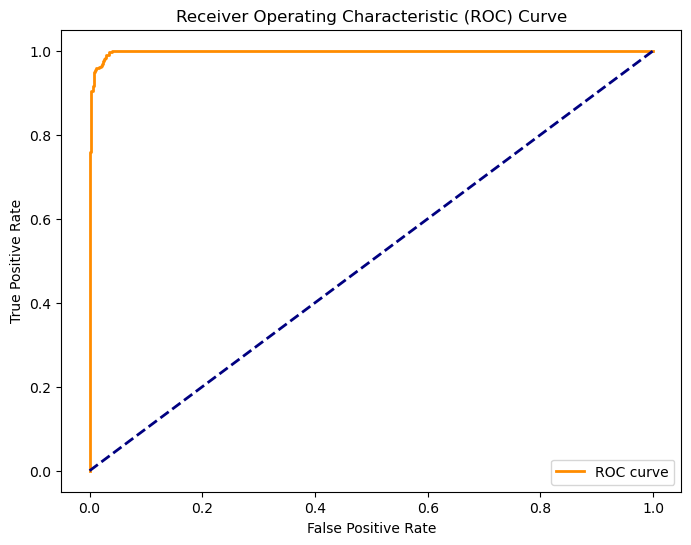

Confusion Matrix:
[[488  17]
 [  5 490]]


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Assuming test_y and test_pred are your true labels and predicted probabilities

# Convert probabilities to binary predictions (0 or 1)
test_pred_class = (test_pred > 0.5).astype(int)

# Calculate and print accuracy
accuracy = accuracy_score(test_y, test_pred_class)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print precision, recall, and F1 score
precision = precision_score(test_y, test_pred_class)
recall = recall_score(test_y, test_pred_class)
f1 = f1_score(test_y, test_pred_class)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate and print ROC AUC
roc_auc = roc_auc_score(test_y, test_pred)
print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix
conf_matrix = confusion_matrix(test_y, test_pred_class)
print('Confusion Matrix:')
print(conf_matrix)

In [33]:
sm.delete_endpoint(EndpointName=xgboost_endpoint)

{'ResponseMetadata': {'RequestId': '06c965e7-58bc-4d89-844f-7e766aeb0928',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '06c965e7-58bc-4d89-844f-7e766aeb0928',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 29 Nov 2023 10:45:27 GMT'},
  'RetryAttempts': 0}}